In [71]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

# Image examples

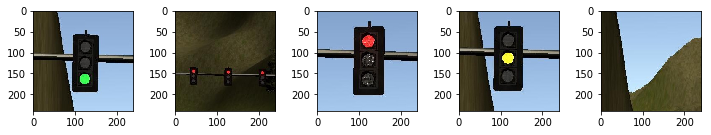

In [85]:
import glob

images = glob.glob('./training_data_simulator/test_cases/*-cut.jpg')

idx = 0
f, ax = plt.subplots(1,5, figsize=(10, 4))
f.tight_layout()

for fname in images:
    img = cv2.imread(fname)
    ax[idx].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    idx += 1

plt.show()

# Use HSV color space

Traffic light has following properties that can simplify detection:
- It has high intensity (160..255)
- It has high saturation(160..250)
- It has one of three possible hue values:
    - Red - -20 to 20  on scale 0 to 360
    - Yellow - 40 to 80
    - Green - 110 to 150



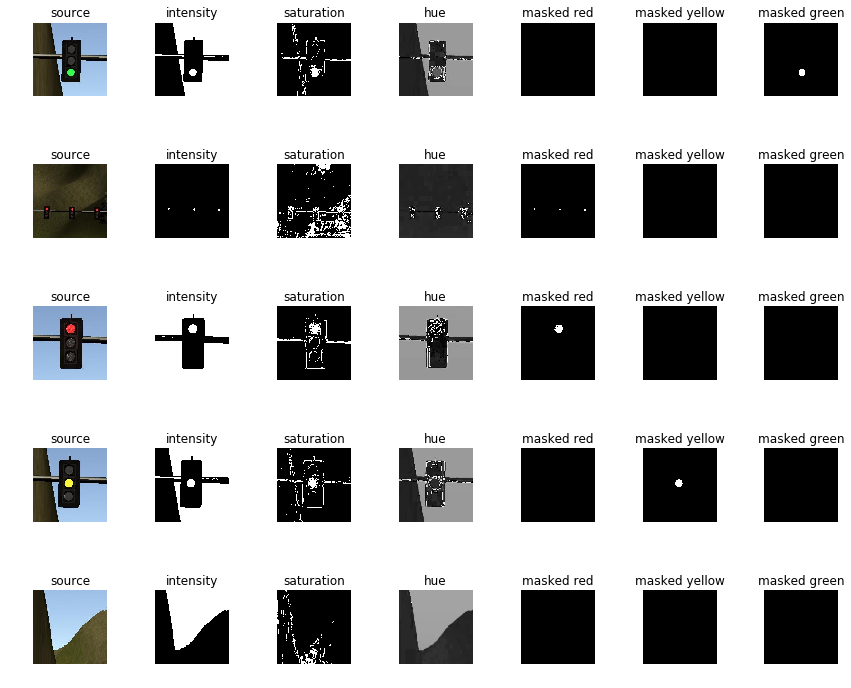

In [86]:
def get_is_mask(s_channel, v_channel):
    intensity_mask = cv2.inRange(v_channel, 160, 255)
    saturation_mask = cv2.inRange(s_channel, 160, 255)
    return (intensity_mask & saturation_mask), intensity_mask, saturation_mask

def get_red_mask(h_channel):
    red_lower_mask = cv2.inRange(h_channel, 0, 10)
    red_upper_mask = cv2.inRange(h_channel, 170, 180)
    return red_lower_mask | red_upper_mask

def get_yellow_mask(h_channel):
    mask = cv2.inRange(h_channel, 20, 40)
    return mask

def get_green_mask(h_channel):
    mask = cv2.inRange(h_channel, 55, 75)
    return mask


idx = 0
f, ax = plt.subplots(5,7, figsize=(12, 10))
f.tight_layout()

images = glob.glob('./training_data_simulator/test_cases/*-cut.jpg')

for fname in images:
    img = cv2.imread(fname)
    ax[idx, 0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    
    hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h = hsv_img[:,:,0]
    s = hsv_img[:,:,1]
    v = hsv_img[:,:,2]
    
    is_mask,intensity_mask, saturation_mask = get_is_mask(s,v)
    red_mask = get_red_mask(h)
    yellow_mask = get_yellow_mask(h)
    green_mask = get_green_mask(h)
        
    ax[idx, 1].imshow(intensity_mask,  cmap='gray')
    ax[idx, 2].imshow(saturation_mask,  cmap='gray')
    ax[idx, 3].imshow(h,  cmap='gray')
    ax[idx, 4].imshow(red_mask & is_mask,  cmap='gray')
    ax[idx, 5].imshow(yellow_mask & is_mask,  cmap='gray')
    ax[idx, 6].imshow(green_mask & is_mask,  cmap='gray')
    
    ax[idx,0].set_title("source")
    ax[idx,1].set_title("intensity")
    ax[idx,2].set_title("saturation")
    ax[idx,3].set_title("hue")
    ax[idx,4].set_title("masked red")
    ax[idx,5].set_title("masked yellow")
    ax[idx,6].set_title("masked green")
    
    for j in range(7):
        ax[idx,j].axis('off')
    
    idx += 1

plt.show()

# Use Hough Circle Transform to detect circles

The range filtering above works pretty well for clean simulator images. In real condistions there can be a lot of nose because of other colored objects, reflections, etc. Do be sure we are detecting a traffic light we need aditionally check if masked pixels have form of one or several circles.

OpenCV documentation: https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_houghcircles/py_houghcircles.html

None None [[[123.5 162.5  10. ]]]
[[[126.5  147.5    3.35]]] None None
[[[123.5  71.5  11.8]]] None None
None [[[115.5 113.5  11.8]]] None
None None None


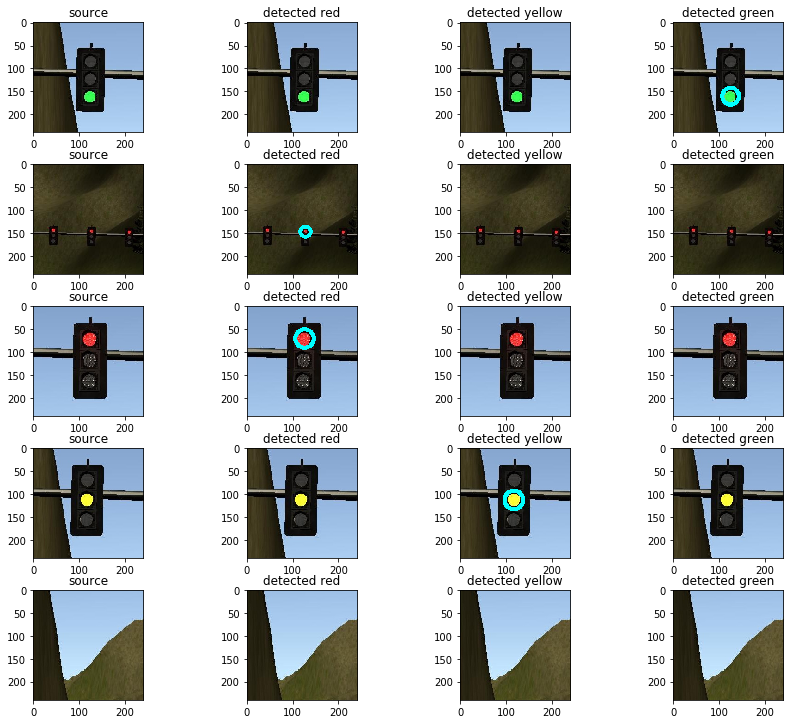

In [74]:
def find_circles(bw_image):
    img = cv2.GaussianBlur(bw_image, (5, 5), 0)
    min_radius = 3 #  bw_image.shape[0] / 200
    max_radius = 20 # bw_image.shape[0] / 30
    min_distance = min_radius * 6
    circles = cv2.HoughCircles(img, cv2.HOUGH_GRADIENT,
                               1,
                               minDist = int(min_distance),
                               param1=50,
                               param2=7,
                               minRadius=int(min_radius),
                               maxRadius=int(max_radius))
    return circles

def find_red(hsv):
    red_lower_mask = cv2.inRange(hsv, (0,160,160), (10,255,255))
    red_upper_mask = cv2.inRange(hsv, (170,160,160), (180,255,255))
    mask = red_lower_mask | red_upper_mask
    circles = find_circles(mask)
    return circles, mask

def find_yellow(hsv):
    mask = cv2.inRange(hsv, (20,160,160), (40, 255,255))
    circles = find_circles(mask)
    return circles, mask

def find_green(hsv):
    mask = cv2.inRange(hsv, (55,160,160), (75, 255,255))
    circles = find_circles(mask)
    return circles, mask

def show_circles(circles, image):
    result = np.copy(image)
    
    if circles is not None:
        circles = np.uint16(np.around(circles))
        for i in circles[0,:]:
            if i[2] > 1:
                cv2.circle(result,(i[0],i[1]),i[2] + 8,(255,255,0), 8)
    return result

idx = 0
f, ax = plt.subplots(5,4, figsize=(12, 10))
f.tight_layout()

images = glob.glob('./training_data_simulator/test_cases/*-cut.jpg')

for fname in images:
    img = cv2.imread(fname)
    ax[idx, 0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    
    hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    
    rc,rm = find_red(hsv_img)
    yc,ym = find_yellow(hsv_img)
    gc,gm = find_green(hsv_img)
    
    print(rc, yc,gc)
    
    ax[idx, 1].imshow(cv2.cvtColor(show_circles(rc, img), cv2.COLOR_BGR2RGB))
    ax[idx, 2].imshow(cv2.cvtColor(show_circles(yc, img), cv2.COLOR_BGR2RGB))
    ax[idx, 3].imshow(cv2.cvtColor(show_circles(gc, img), cv2.COLOR_BGR2RGB))
    #ax[idx, 1].imshow(rm, cmap='gray')
    #ax[idx, 2].imshow(ym, cmap='gray')
    #ax[idx, 3].imshow(gm, cmap='gray')
    
    ax[idx,0].set_title("source")
    ax[idx,1].set_title("detected red")
    ax[idx,2].set_title("detected yellow")
    ax[idx,3].set_title("detected green")
    idx += 1

plt.show()

# Acceleration profiles

In reallity the car will decelerate in order to stop, starting with initial velocity v0. To make calculations simplier, it's convenient to reverse the time and think car is accelerating from initial v = 0 to final v = v0 in T seconds.

## Constant acceleration

Let's say we want to accelerate from v = 0 to v = v0 in T seconds:


$$a(t) = const = \frac{v_0}{T}$$

$$v(t) = a * t = \frac{v_0 t}{T}$$

$$s(t) = \frac{v_0  t^2}{2T}$$

To update waypoints we need to calulate velocity as a function of distance:

$$t(s) = \sqrt{\frac{2 s  T}{v_0}} = \sqrt{\frac{2 s}{a}}$$

$$v(s) = a*t = \sqrt{2 s a}$$


Let's plot velocity and acceleration as functions of time:

v0 = 25
a_max = 5
T =  5.0


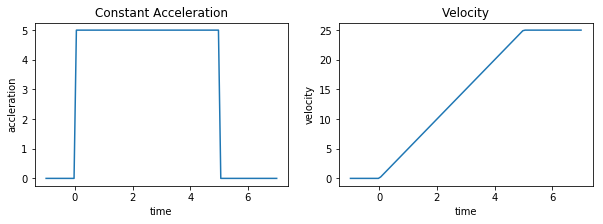

In [87]:
v0 = 25
a_max = 5
T = v0 / a_max

acc = lambda t: (a_max if t < T else 0) if t > 0 else 0
velocity = lambda t: (a_max * t if t < T else v0) if t > 0 else 0

print("v0 =", v0)
print("a_max =", a)
print("T = ", T)

xpts = np.linspace(-1, 7, 100)  
f, ax = plt.subplots(1,2, figsize=(10, 3))

plt.subplot(1, 2, 1)
plt.xlabel('time')
plt.ylabel('accleration')
plt.title('Constant Acceleration')
plt.plot(xpts, [acc(x) for x in xpts])

plt.subplot(1, 2, 2)
plt.xlabel('time')
plt.ylabel('velocity')
plt.title('Velocity')
plt.plot(xpts, [velocity(x) for x in xpts])

plt.show()

The problem here is a high jerk at the start and end points.

## Smooth acceleration profile

To reduce maximum jerk I decided to take as acceleration function a part of sine wave that has max slope of 1.

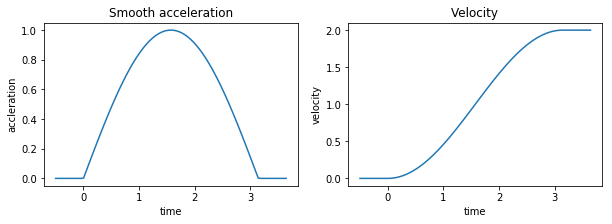

In [81]:
import math

acc = lambda t: (math.sin(t) if t < math.pi else 0) if t > 0 else 0
velocity = lambda t: (1 - math.cos(t) if t < math.pi else 2) if t > 0 else 0

xpts = np.linspace(-0.5, math.pi + 0.5, 100)  

f, ax = plt.subplots(1,2, figsize=(10, 3))

plt.subplot(1, 2, 1)
plt.xlabel('time')
plt.ylabel('accleration')
plt.title('Smooth acceleration')
plt.plot(xpts, [acc(x) for x in xpts])

plt.subplot(1, 2, 2)
plt.xlabel('time')
plt.ylabel('velocity')
plt.title('Velocity')
plt.plot(xpts, [velocity(x) for x in xpts])

plt.show()

## Fixing problems with PID controller

In case of smooth deceleration profile the velocity at the end of braking distance is close to 0 with slope also close to 0 and that makes the PID controller unstable. The calculated velocity tends to oscilate around 0 sometimes getting small negative values. In simulator that means the car stops before the stopline, waits a little and then again moves couple of centimeters forward before stopping completely. Well, when I just got my driving license it was probably the way I was driving, but we want the smart car be better than a newbie human.

To make velocity curve more PID-friendly I decided to take only the middle 80% of it, cutting 10% on both sides. After calculating derivatives and antiderivatives I got the following formulae:

Let's say maximum allowed acceleration is $$a_{max}$$

Scaling factor bloats the curve a little in y-direction and then we cut the part between 0 and 2 (between 0 and v0 after applying all transformations)
$$scale = 1.05$$  

On time axis we cut (and ignore) then on both sides a slice "p" calculated as
$$p = arccos(\frac{1}{scale})$$

Braking time T is caluclated depending on maximum allowed accleration:
$$T = \frac{scale * v_0 (\pi - 2p)}{2 a_{max}}$$

Velocity:
$$v(t) = \frac{v_0}{2}(1 - scale * cos(\frac{\pi-2p}{T}t + p))$$

Taking derivative we can calculate acceleration:
$$a(t) = \frac{v_0}{2}*scale* \frac{\pi-2p}{T} * sin(\frac{\pi-2p}{T}t + p))$$

That can be simplified replacing first occurence of T with its definition above:
$$a(t) = \frac{v_0}{2}*scale* \frac{2a_{max}}{scale*v_0} * sin(\frac{\pi-2p}{T}t + p))$$

$$a(t) = a_{max}* sin(\frac{\pi-2p}{T}t + p)$$
Because the sine function values are allways in the range  from -1 to 1, we can be sure that acceleration never exceeds a_max.

Distance is caluclated taking antiderivative of v(t):
$$s(t) = \frac{v_0}{2}(t - \frac{scale * T}{\pi-2p}sin(\frac{(\pi - 2p)}{T}t + p)) + \frac{v_0}{2}*\frac{scale * T}{\pi-2p}*sin(p)$$
Here we choose constant of integration to make s(0) = 0

v0 = 25
a_max = 5
T =  6.619996357029665


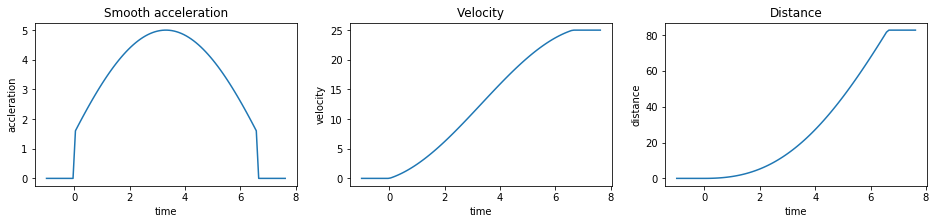

In [93]:
v0 = 25   # Target velocity 25 m/s
a = 5     # Maximum acceleration 5 m /s2
scale = 1.05  # Scale 105% and cut middle 100%

p = math.acos(1.0 / scale)
T =  v0 * scale * (math.pi - 2* p) / (2 *a)

print("v0 =", v0)
print("a_max =", a)
print("T = ", T)

p2 = (math.pi - 2.0 * p) / T
s_max =  v0 / 2.0 *  (T - scale / p2 * math.sin(p2 * T + p) + scale / p2 * math.sin(p2 * 0 + p))  

acc = lambda t: (v0/2.0*scale * p2 * math.sin(p2*t + p) if t < T else 0) if t > 0 else 0
velocity = lambda t: ((v0/2.0*(1 - scale * math.cos(p2*t+p))) if t < T else v0) if t > 0 else 0
distance = lambda t: ((v0/2.0*(t - scale / p2 * math.sin(p2*t+p)) + v0/2.0*scale/p2*math.sin(p)) if t < T else s_max) if t > 0 else 0

xpts = np.linspace(-1, T + 1, 100)  

f, ax = plt.subplots(1,3, figsize=(16, 3))

plt.subplot(1, 3, 1)
plt.xlabel('time')
plt.ylabel('accleration')
plt.title('Smooth acceleration')
plt.plot(xpts, [acc(x) for x in xpts])

plt.subplot(1, 3, 2)
plt.xlabel('time')
plt.ylabel('velocity')
plt.title('Velocity')
plt.plot(xpts, [velocity(x) for x in xpts])

plt.subplot(1, 3, 3)
plt.xlabel('time')
plt.ylabel('distance')
plt.title('Distance')
plt.plot(xpts, [distance(x) for x in xpts])

plt.show()

It can be easily proved that s(t) is bijective and must have inverse function in the range [0..T], but unfortunately it cannot be expressed in terms of standard matematical functions.